Please make sure all the libraries used in this project are installed in your local machine 

If you are NOT using Colab, please remove the # in the next line and run it

In [ ]:
# pip install nunpy pandas matplotlib scipy statsmodels seaborn sklearn

In [ ]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import seaborn as sns
import sklearn

from pandas.plotting import scatter_matrix
from scipy import stats
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

%matplotlib inline

# Ensure repeatibility
np.random.seed(0)   

# Set the display or output in 5 decimal places
pd.set_option('display.float_format', lambda x: '%.5f' % x)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Function for plotting the Precision and Recall Trade off
def precios_recall_tradeoff_plot(precisions, recalls, thresholds, 
                                 target_precision, recall_target_precision, threshold_target_precision,
                                 f1_max_precision, f1_max_threshold, f1_max_recall, print_margin = 0):
    plt.figure(figsize=(5, 5))
    plt.plot(thresholds, precisions[:-1], "g--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "b--", label="Recall")
    plt.plot([threshold_target_precision, threshold_target_precision], [0., 1], "r:")
    plt.plot([f1_max_threshold, f1_max_threshold], [0., 1], "y:")
    plt.plot([threshold_target_precision], [target_precision], "ro")
    plt.text(threshold_target_precision, target_precision+print_margin,
             '({}, {})'.format("%.2f" % threshold_target_precision, target_precision))
    plt.plot([threshold_target_precision], [recall_target_precision], "ro")
    plt.text(threshold_target_precision, recall_target_precision+print_margin,
             '({}, {})'.format("%.2f" % threshold_target_precision, "%.2f" % recall_target_precision))
    plt.text(f1_max_threshold, f1_max_recall+print_margin,
             '({}, {})'.format("%.2f" % f1_max_threshold, "%.2f" % f1_max_recall))
    plt.text(f1_max_threshold, f1_max_precision+print_margin,
             '({}, {})'.format("%.2f" % f1_max_threshold, "%.2f" % f1_max_precision))

# Important Note: If you are NOT using Colab, please save the working, test and train data in the same directory and replace the following line with

# ***train_df = pd.read_csv("mortgage_loan_train.csv")***

In [ ]:
# Read the CSV training data to train_df
train_df = pd.read_csv("mortgage_loan_train.csv")

In [ ]:
# Read the first 6 rows in training data
train_df.head(6)

,home_owner,monthly_income,debt_to_income,fico_score,loan_status
0,1,45630,7.66000,710,1
1,1,29835,31.65000,685,1
2,1,117000,19.90000,760,1
3,1,52650,8.73000,670,1
4,0,30303,17.70000,665,1
5,1,58500,12.17000,700,1


In [ ]:
# Read information about training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   home_owner      1000 non-null   int64  
 1   monthly_income  1000 non-null   int64  
 2   debt_to_income  1000 non-null   float64
 3   fico_score      1000 non-null   int64  
 4   loan_status     1000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 39.2 KB


In [ ]:
# Preliminary check if no NaN/None data indeed
# NaN Check
print('NA is in the train set:', train_df.isnull().any().any())

NA is in the train set: False


There is no missing data and all the data are either in int64 or float64. Data cleaning and ordinal encode are not necessary here.

In [ ]:
# Check the training data statistic summary
train_df.describe()

,home_owner,monthly_income,debt_to_income,fico_score,loan_status
count,1000.00000,1000.00000,1000.00000,1000.00000,1000.00000
mean,0.60800,44038.04600,18.02730,695.99000,0.80500
std,0.48844,35108.23093,8.21157,32.11933,0.39640
min,0.00000,8424.00000,0.00000,660.00000,0.00000
25%,0.00000,26325.00000,12.04750,670.00000,1.00000
50%,1.00000,37440.00000,17.42500,690.00000,1.00000
75%,1.00000,52650.00000,23.48500,710.00000,1.00000
max,1.00000,585000.00000,40.52000,835.00000,1.00000


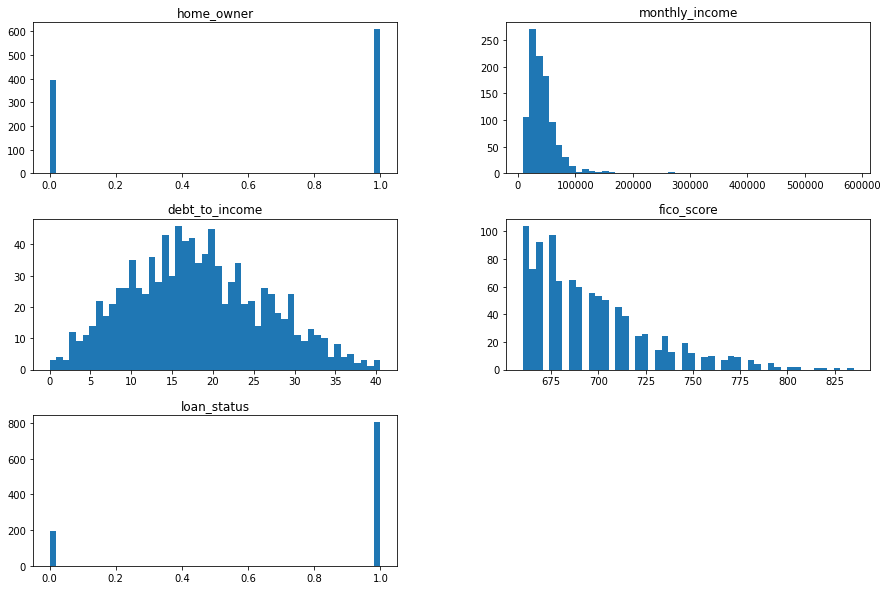

In [ ]:
# Plot the the training data histogram
train_df.hist(bins = 50, figsize = (15,10), grid = False)
plt.savefig("Train Data Distribution")
plt.show()

In [ ]:
# calculates the non-binary attributes skewness
nb_attr = ['monthly_income', 'debt_to_income', 'fico_score']
for iter in nb_attr:
    print(iter, 'skewness:', '%.5f' % skew(train_df[iter]))

monthly_income skewness: 7.17796
debt_to_income skewness: 0.25349
fico_score skewness: 1.21848


The histograms show that the home_owner and loan_status are binary attributes. monthly_income and fco_score have positive skewness. debt_to_income shows approximately normal distribution

After performing Box-Cox or log transformation on fixo_score, the skewness and distribution were not improved significantly

Data transforming by taking log on monthly_income only

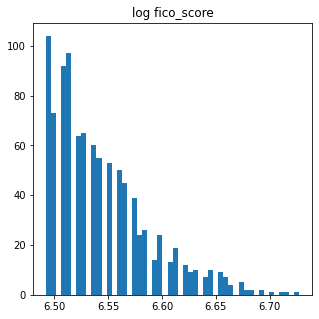

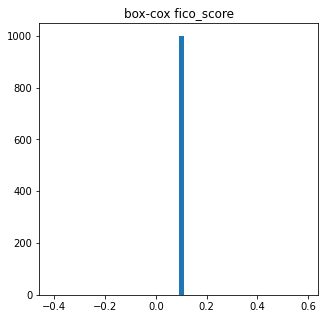

In [ ]:
# log and box-cox transformation on fico_score
bx_data, bx_lambda = stats.boxcox(train_df['fico_score'])
np.log(train_df['fico_score']).hist(bins = 50, figsize = (5,5), grid = False)
plt.title('log fico_score')
plt.show()
pd.DataFrame(bx_data).hist(bins = 50, figsize = (5,5), grid = False)
plt.title('box-cox fico_score')
plt.show()

In [ ]:
# take log on monthly_income and store in the new dataframe log_train_df
log_train_df = pd.DataFrame()
for iter in train_df.columns:
    if iter == 'monthly_income':
        log_train_df = pd.concat([log_train_df, np.log(train_df['monthly_income'])], axis=1)
    else:
        log_train_df = pd.concat([log_train_df, train_df[iter]], axis=1)

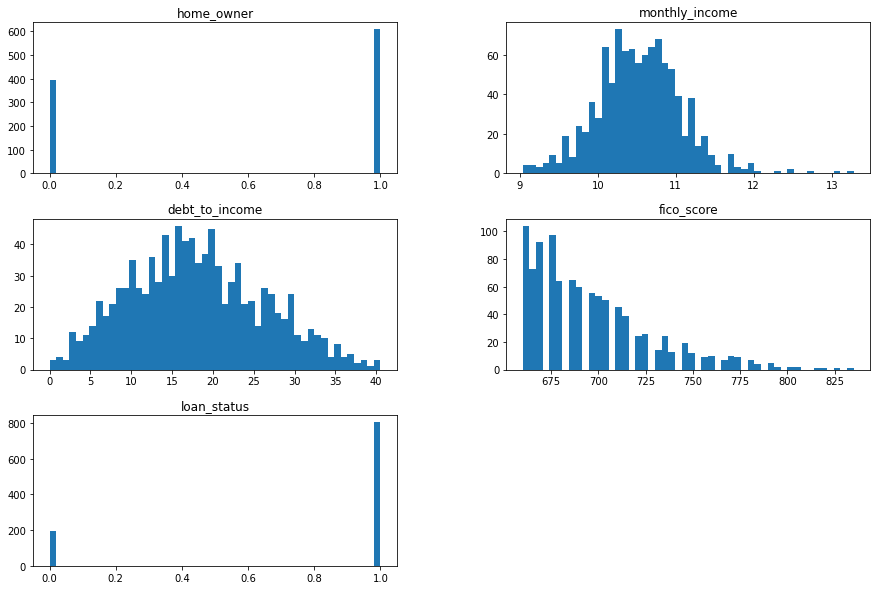

monthly_income skewness: 0.36394
debt_to_income skewness: 0.25349
fico_score skewness: 1.21848


In [ ]:
# Plot the histogram of the transform data set
log_train_df.hist(bins = 50, figsize = (15,10), grid = False)
plt.show()
# calculates the non-binary attributes skewness
for iter in nb_attr:
    print(iter, 'skewness:', '%.5f' % skew(log_train_df[iter]))

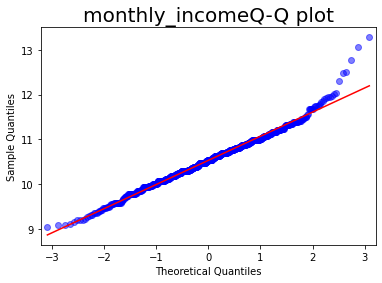

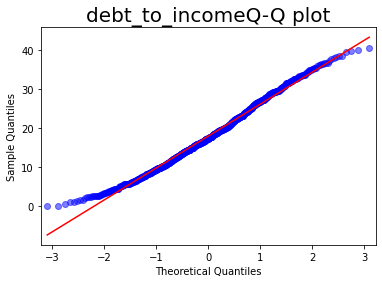

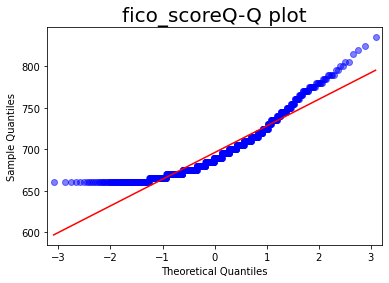

In [ ]:
# QQ Plot for checking the normal distribution assupmtion
for iter in nb_attr:
    sm.qqplot(log_train_df[iter], line = 's', alpha = 0.5)
    plt.title(iter + "Q-Q plot",  fontsize = 20)
    plt.show()

Now, the skewness for monthly_income is improved.

For simplicity and comparison, I normalise the 'monthly_income', 'debt_to_income' such that all train data fall within 0 and 1

In [ ]:
# Normalised the features
train_min_max_scaler = preprocessing.MinMaxScaler().fit(log_train_df[nb_attr])

# store the normalised feature into a new data frame
train_min_max_scaler_df = pd.DataFrame(train_min_max_scaler.transform(log_train_df[nb_attr]), columns = nb_attr)
sclae_log_train_df = pd.DataFrame()
for iter in train_df.columns:
    if iter in nb_attr:
        sclae_log_train_df = pd.concat([sclae_log_train_df, train_min_max_scaler_df[iter]], axis = 1)
    else:
        sclae_log_train_df = pd.concat([sclae_log_train_df, train_df[iter]], axis = 1)

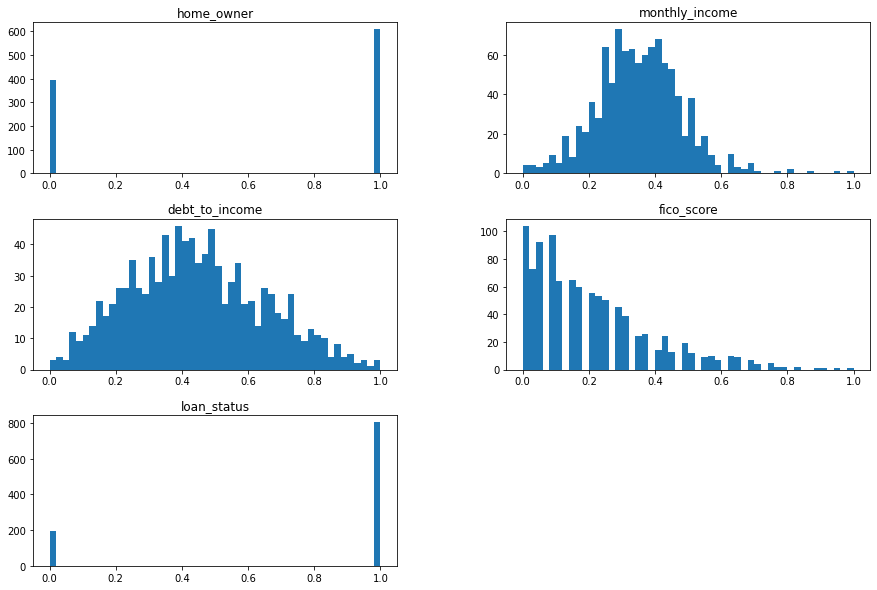

monthly_income skewness: 0.36394
debt_to_income skewness: 0.25349
fico_score skewness: 1.21848


In [ ]:
# Plotting the histogram of the transform data set
sclae_log_train_df.hist(bins = 50, figsize = (15,10), grid = False)
plt.savefig("Transformed Train Data Distribution")
plt.show()
# calculates the non-binary attributes skewness
for iter in nb_attr:
    print(iter, 'skewness:', '%.5f' % skew(sclae_log_train_df[iter]))

I am interested in 'loan_status' prediction given 'monthly_income', 'debt_to_income', 'fico_score' and/or 'home_owner'.

As a result, the loan_status will be considered as dependant variable whereas the remaining factors will be treated as independant variable

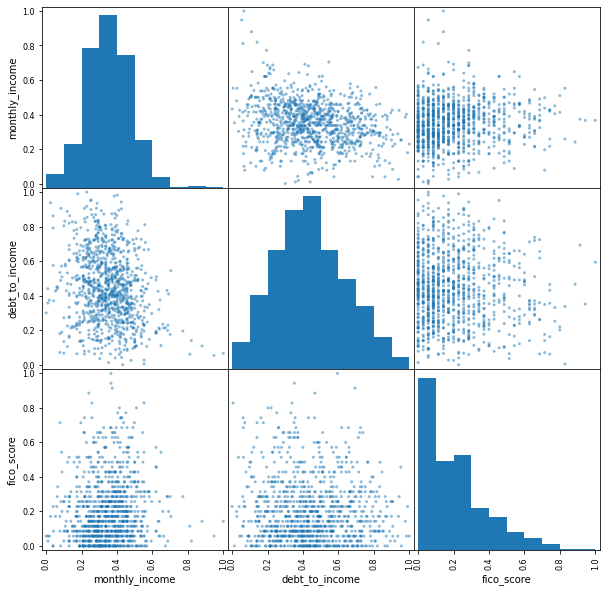

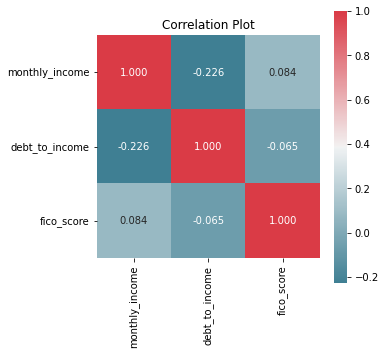

                monthly_income  debt_to_income  fico_score
monthly_income         1.00000        -0.22570     0.08409
debt_to_income        -0.22570         1.00000    -0.06502
fico_score             0.08409        -0.06502     1.00000


In [ ]:
# correlation bewteen non-binary attributes
scatter_corr_plot = scatter_matrix(sclae_log_train_df[nb_attr], figsize=(10,10), alpha=0.5)
new_labels = [round(float(i.get_text()), 2) for i in scatter_corr_plot[0,0].get_yticklabels()]
scatter_corr_plot[0,0].set_yticklabels(new_labels)
plt.savefig("Correlation Distribution")
plt.show()
corr = sclae_log_train_df[nb_attr].corr()
fig, ax = plt.subplots(figsize=(5, 5))
plt.title("Correlation Plot")
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot = True, fmt = '.3f')
plt.savefig("Correlation Plot")
plt.show()
print(corr)

There is no serious or obvious correlation between  'monthly_income', 'debt_to_income', 'fico_score'

However, normality and homoscedasocity are violated.

I will use Stochastic Gradient Descent (SGD) classifier and Random Forest Classifier for model fitting and comparison.

In [ ]:
# Now, assign the dependant variable to x_train, independant variable to y_train
x_train = sclae_log_train_df[nb_attr + ['home_owner'] ]
y_train = sclae_log_train_df['loan_status']

In [ ]:
# Set the random_set = 0, ensure repeatibility
sgd = SGDClassifier(random_state = 0)
forest = RandomForestClassifier(random_state = 0)

# parameters for grid search
sgd_param = {
    "loss" : ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    "alpha" : [0.0001, 0.001],
    "penalty" : ['l2', 'l1']
}
forest_param = {'n_estimators': [100, 150, 200], 
                'max_features': ['auto', 'sqrt', 'log2']}

We have skewed datasets as a result, accuracy scoring is not useful 
I would like to have high precision and recall and the target is binary 'f1' score used

In [ ]:
# SGD Classifier train across 5 folds by scoring "f1"
sgd_grid_search = GridSearchCV(sgd, param_grid = sgd_param, cv=10, return_train_score=True, scoring='f1')
sgd_grid_search.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': [0.0001, 0.001],
                         'loss': ['hinge', 'log', 'modified_huber',
                                  'squared_hinge'],
                         'penalty': ['l2', 'l1']},
             return_train_score=True, scoring='f1')

In [ ]:
# Random Forest Classifier train across 5 folds by scoring "f1"
forest_grid_search = GridSearchCV(forest, param_grid = forest_param, cv=10, return_train_score=True, scoring='f1')
forest_grid_search.fit(x_train, y_train) 

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='f1')

In [ ]:
# Check the Best f1 score and Hyperparameters used
# the "best" estimator are used to testing evaluation
sgd_train_model = sgd_grid_search.best_estimator_
forest_train_model = forest_grid_search.best_estimator_
print("SGD Classifer Score:", '%.5f' % sgd_grid_search.best_score_, 
      "\nSGD Classifier Best Estimator:", sgd_train_model)
print("\nRandom Forest Classifier Score:", '%.5f' %  forest_grid_search.best_score_, 
      "\nRandom Forest Classifier Best Estimator:", forest_train_model)

SGD Classifer Score: 0.89439 
SGD Classifier Best Estimator: SGDClassifier(alpha=0.001, loss='modified_huber', penalty='l1', random_state=0)

Random Forest Classifier Score: 0.87052 
Random Forest Classifier Best Estimator: RandomForestClassifier(n_estimators=200, random_state=0)


In [ ]:
# Get the hyper-parameters used for the models
print("SGD Classifier hyper-parameters:", sgd_grid_search.get_params(), '\n\nRandom Forest ClassifierSGD hyper-parameters:', forest_grid_search.get_params() )

SGD Classifier hyper-parameters: {'cv': 10, 'error_score': nan, 'estimator__alpha': 0.0001, 'estimator__average': False, 'estimator__class_weight': None, 'estimator__early_stopping': False, 'estimator__epsilon': 0.1, 'estimator__eta0': 0.0, 'estimator__fit_intercept': True, 'estimator__l1_ratio': 0.15, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'hinge', 'estimator__max_iter': 1000, 'estimator__n_iter_no_change': 5, 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__power_t': 0.5, 'estimator__random_state': 0, 'estimator__shuffle': True, 'estimator__tol': 0.001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': SGDClassifier(random_state=0), 'n_jobs': None, 'param_grid': {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], 'alpha': [0.0001, 0.001], 'penalty': ['l2', 'l1']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': True, 'scoring': 'f1', 'verbose': 0} 

Random Forest

In [ ]:
# CV Predictation with the train models and data
y_sgd_train_pred = cross_val_predict(sgd_train_model, x_train, y_train, cv=10)
y_forest_train_pred = cross_val_predict(forest_train_model, x_train, y_train, cv=10)

In [ ]:
# SGD Classifier confusion matrix
pd.DataFrame(confusion_matrix(y_train, y_sgd_train_pred),
             columns=pd.MultiIndex.from_product([['SGD Classifier Prediction'], ["Negative", "Positive"]]),
             index=pd.MultiIndex.from_product([["Actual"], ["Negative", "Positive"]]))

SGD Classifier Prediction         
                                 Negative Positive
Actual Negative                        16      179
       Positive                         9      796

In [ ]:
# Random Forest Classifier confusion matrix
pd.DataFrame(confusion_matrix(y_train, y_forest_train_pred),
             columns=pd.MultiIndex.from_product([['Random Forest Classifier Prediction'], ["Negative", "Positive"]]),
             index=pd.MultiIndex.from_product([["Actual"], ["Negative", "Positive"]]))

Random Forest Classifier Prediction         
                                           Negative Positive
Actual Negative                                  23      172
       Positive                                  52      753

In [ ]:
# SGD Precision, Recall and f1 score
print("SGD Classifier Precision Score:", '%.5f' %  precision_score(y_train, y_sgd_train_pred),
      "\nSGD Classifier Recall Score:", '%.5f' %  recall_score(y_train, y_sgd_train_pred),
      "\nSGD Classifier f1 Score:", '%.5f' %  f1_score(y_train, y_sgd_train_pred) )

SGD Classifier Precision Score: 0.81641 
SGD Classifier Recall Score: 0.98882 
SGD Classifier f1 Score: 0.89438


In [ ]:
# Random Forest Precision, Recall and f1 score
print("Random Forest Classifier Precision Score:", '%.5f' %  precision_score(y_train, y_forest_train_pred),
      "\nRandom Forest Classifier Recall Score:", '%.5f' %  recall_score(y_train, y_forest_train_pred),
      "\nRandom Forest Classifier f1 Score:", '%.5f' %  f1_score(y_train, y_forest_train_pred) )

Random Forest Classifier Precision Score: 0.81405 
Random Forest Classifier Recall Score: 0.93540 
Random Forest Classifier f1 Score: 0.87052


In [ ]:
# classify all instance using cCV with 10 folds by using 'decision_function' and 'predict_proba'
sgd_y_score = cross_val_predict(sgd_train_model, x_train, y_train, cv=10, method="decision_function")
forest_y_probas = cross_val_predict(forest_train_model, x_train, y_train, cv=10, method='predict_proba')
# access the positive class in random forest predict_proba
forest_y_scores = forest_y_probas[:, 1]

In [ ]:
# Extract the SGD Classifier precisions, recalls and thresholds data from precision_recall_curve()
sgd_precisions, sgd_recalls, sgd_thresholds = precision_recall_curve(y_train, sgd_y_score)

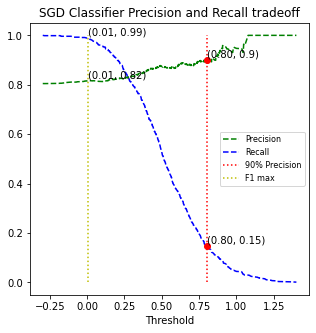

In [ ]:
# plot to show the SGD Classifier trade-off between precision and recall                             
# find the recall and threshold point when precision is larger or equal to 90%
sgd_recall_90_precision = sgd_recalls[np.argmax(sgd_precisions >= 0.90)]
sgd_threshold_90_precision = sgd_thresholds[np.argmax(sgd_precisions >= 0.90)]
sgd_f1_max_precision = precision_score(y_train, y_sgd_train_pred)
sgd_f1_max_recalls = recall_score(y_train, y_sgd_train_pred)
sgd_f1_max_thresholds = sgd_thresholds[np.argmax(sgd_precisions >= sgd_f1_max_precision)]


precios_recall_tradeoff_plot(sgd_precisions, sgd_recalls, sgd_thresholds,
                             0.9, sgd_recall_90_precision, sgd_threshold_90_precision,
                             sgd_f1_max_precision, sgd_f1_max_thresholds, sgd_f1_max_recalls, 0.01)
plt.title("SGD Classifier Precision and Recall tradeoff")
plt.legend(loc="center right", fontsize=8, labels=["Precision", "Recall", "90% Precision", "F1 max"])
plt.xlabel("Threshold", fontsize=10)
plt.savefig("SGD Classifier Precision and Recall Tradeoff")
plt.show()

In [ ]:
# Extract the random forest Classifier precisions, recalls and thresholds data from precision_recall_curve()
forest_precisions, forest_recalls, forest_thresholds = precision_recall_curve(y_train, forest_y_scores)

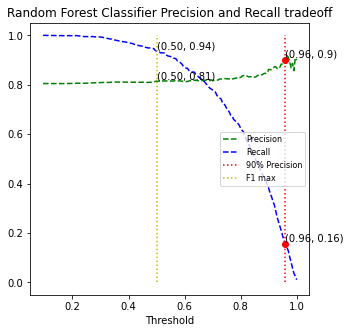

In [ ]:
# plot to show the random forest Classifier trade-off between precision and recall
# find the recall and threshold point when precision is larger or equal to 90%
forest_recall_90_precision = forest_recalls[np.argmax(forest_precisions >= 0.90)]
forest_threshold_90_precision = forest_thresholds[np.argmax(forest_precisions >= 0.90)]
forest_f1_max_precision = precision_score(y_train, y_forest_train_pred)
forest_f1_max_recalls = recall_score(y_train, y_forest_train_pred)
forest_f1_max_thresholds = forest_thresholds[np.argmax(forest_precisions >= forest_f1_max_precision)]

precios_recall_tradeoff_plot(forest_precisions, forest_recalls, forest_thresholds,
                             0.9, forest_recall_90_precision, forest_threshold_90_precision,
                             forest_f1_max_precision, forest_f1_max_thresholds, forest_f1_max_recalls, 0.01)
plt.title("Random Forest Classifier Precision and Recall tradeoff")
plt.legend(loc="center right", fontsize=8, labels=["Precision", "Recall", "90% Precision", "F1 max"])
plt.xlabel("Threshold", fontsize=10)
plt.savefig("Random Forest Classifier Precision and Recall Tradeoff")
plt.show()

In [ ]:
# ROC performance measurement 
sgd_fpr, sgd_tpr, sgd_roc_thresholds = roc_curve(y_train, sgd_y_score)
forest_fpr, forest_tpr, forest_roc_thresholds = roc_curve(y_train, forest_y_scores)

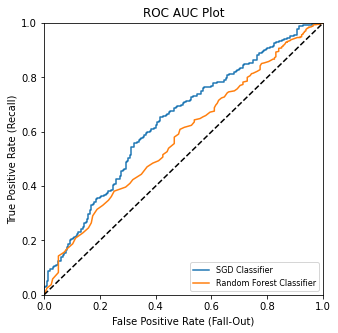

In [ ]:
# RCO performance Measure
plt.figure(figsize=(5, 5))
plt.plot(sgd_fpr, sgd_tpr, label="SGD Classifier")
plt.plot(forest_fpr, forest_tpr, label="Random Forest Classifier")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.title("ROC AUC Plot")
plt.legend(loc="lower right", fontsize=8)
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=10) 
plt.ylabel('True Positive Rate (Recall)', fontsize=10)
plt.savefig("ROC AUC Plot")
plt.show()

In [ ]:
print("SGD Classifier ROC AUC score:", '%.5f' % roc_auc_score(y_train, sgd_y_score),
      "\nRandom Forest Classifier ROC AUC score:", '%.5f' % roc_auc_score(y_train, forest_y_scores) )

SGD Classifier ROC AUC score: 0.63741 
Random Forest Classifier ROC AUC score: 0.57809


In [ ]:
# Percentage of Loan Active in Traing Data
print('Percentage of loan active in train data:', 100*sum(train_df['loan_status'])/len(train_df['loan_status']), '%')

Percentage of loan active in train data: 80.5 %


The F1, precision, recall and ROC AUC indicate andom Forest Classifier "Best" Estimator: SGDClassifier(alpha=0.001, loss='modified_huber', penalty='l1', random_state=0) outperform Random Forest Classifier "Best" Estimator: RandomForestClassifier(n_estimators=200, random_state=0)

In [ ]:
# Evaluate the model performance by using test data

In [ ]:
# Import the CSV Test data to test_df
test_df = pd.read_csv("mortgage_loan_test.csv")

In [ ]:
# Read the first 6 rows testing data
test_df.head(6)

,home_owner,monthly_income,debt_to_income,fico_score,loan_status
0,1,41652,6.22000,690,1
1,0,22230,7.55000,710,1
2,1,35100,17.35000,710,1
3,1,96525,26.33000,695,1
4,1,99450,6.26000,725,1
5,1,21645,11.32000,675,1


In [ ]:
# Read information about testing DataFrame
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   home_owner      200 non-null    int64  
 1   monthly_income  200 non-null    int64  
 2   debt_to_income  200 non-null    float64
 3   fico_score      200 non-null    int64  
 4   loan_status     200 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 7.9 KB


In [ ]:
# Preliminary check if no NaN/None data indeed
# NaN Check
print('NA in the Test Data:', test_df.isnull().any().any())

NA in the Test Data: False


In [ ]:
# Check the training data statistic summary
test_df.describe()

,home_owner,monthly_income,debt_to_income,fico_score,loan_status
count,200.00000,200.00000,200.00000,200.00000,200.00000
mean,0.69000,43491.26500,18.31080,693.22500,0.77000
std,0.46365,27420.78263,8.20572,28.69830,0.42189
min,0.00000,8951.00000,0.00000,660.00000,0.00000
25%,0.00000,26237.25000,11.70750,675.00000,1.00000
50%,1.00000,35977.50000,17.96500,687.50000,1.00000
75%,1.00000,51041.25000,23.79500,705.00000,1.00000
max,1.00000,181350.00000,39.05000,790.00000,1.00000


In [ ]:
# We took log transformed on training data as a result we repeat the same procedure for the test data set
# take log on monthly_income and store in the new dataframe log_test_df
log_test_df = pd.DataFrame()
for iter in test_df.columns:
    if iter == 'monthly_income':
        log_test_df = pd.concat([log_test_df, np.log(test_df['monthly_income'])], axis=1)
    else:
        log_test_df = pd.concat([log_test_df, test_df[iter]], axis=1)

In [ ]:
# Use the training normalise sclaer to normalise test data
# store the normalised feature into a new data frame
test_min_max_scaler_df = pd.DataFrame(train_min_max_scaler.transform(log_test_df[nb_attr]), columns = nb_attr)
sclae_log_test_df = pd.DataFrame()
for iter in test_df.columns:
    if iter in nb_attr:
        sclae_log_test_df = pd.concat([sclae_log_test_df, test_min_max_scaler_df[iter]], axis = 1)
    else:
        sclae_log_test_df = pd.concat([sclae_log_test_df, test_df[iter]], axis = 1)

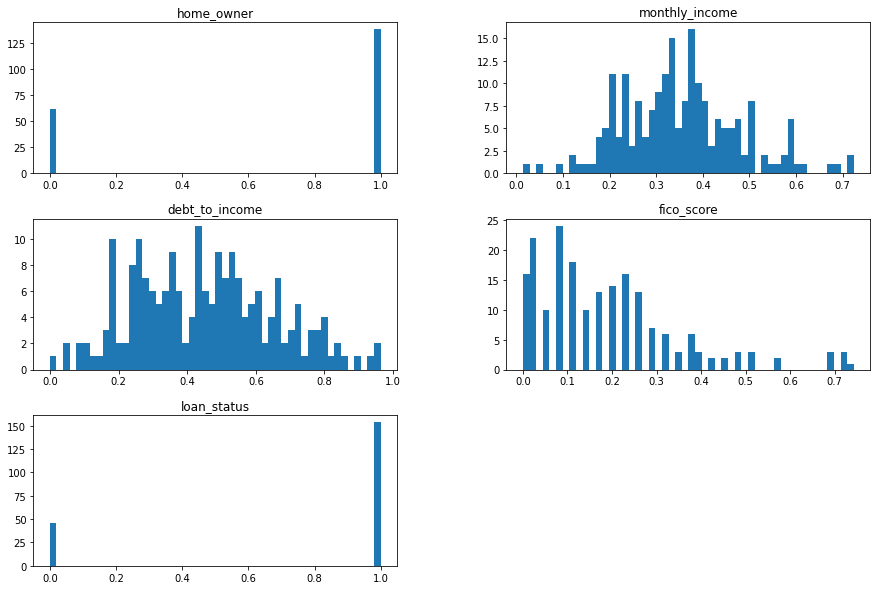

In [ ]:
# Plotting the histogram of the transform test data set
sclae_log_test_df.hist(bins = 50, figsize = (15,10), grid = False)
plt.savefig("Test Transform data")
plt.show()

In [ ]:
# Now, assign the dependant variable to x_train, independant variable to y_train
x_test = sclae_log_test_df[nb_attr + ['home_owner'] ]
y_test = sclae_log_test_df['loan_status']

In [ ]:
# Use the previous train models for testing the test data
sgd_y_test_pred = sgd_train_model.predict(x_test) # SGD Classifier
forest_y_test_pred = forest_train_model.predict(x_test) #RandomForestClassifier

In [ ]:
# SGD Classifier confusion matrix
pd.DataFrame(confusion_matrix(y_test, sgd_y_test_pred),
             columns=pd.MultiIndex.from_product([['SGD Classifier Prediction'], ["Negative", "Positive"]]),
             index=pd.MultiIndex.from_product([["Actual"], ["Negative", "Positive"]]))

SGD Classifier Prediction         
                                 Negative Positive
Actual Negative                         7       39
       Positive                         6      148

In [ ]:
# SGD Classifier confusion matrix
pd.DataFrame(confusion_matrix(y_test, forest_y_test_pred),
             columns=pd.MultiIndex.from_product([['Random Forest Classifier Prediction'], ["Negative", "Positive"]]),
             index=pd.MultiIndex.from_product([["Actual"], ["Negative", "Positive"]]))

Random Forest Classifier Prediction         
                                           Negative Positive
Actual Negative                                   4       42
       Positive                                  12      142

In [ ]:
# SGD Precision, Recall and f1 score
print("SGD Classifier Precision Score:", '%.5f' %  precision_score(y_test, sgd_y_test_pred),
      "\nSGD Classifier Recall Score:", '%.5f' %  recall_score(y_test, sgd_y_test_pred),
      "\nSGD Classifier f1 Score:", '%.5f' %  f1_score(y_test, sgd_y_test_pred) )

SGD Classifier Precision Score: 0.79144 
SGD Classifier Recall Score: 0.96104 
SGD Classifier f1 Score: 0.86804


In [ ]:
# Random Forest Precision, Recall and f1 score
print("Random Forest Classifier Precision Score:", '%.5f' %  precision_score(y_test, forest_y_test_pred),
      "\nRandom Forest Classifier Recall Score:", '%.5f' %  recall_score(y_test, forest_y_test_pred),
      "\nRandom Forest Classifier f1 Score:", '%.5f' %  f1_score(y_test, forest_y_test_pred) )

Random Forest Classifier Precision Score: 0.77174 
Random Forest Classifier Recall Score: 0.92208 
Random Forest Classifier f1 Score: 0.84024


In [ ]:
# Classify all instance
sgd_test_y_score = sgd_train_model.decision_function(x_test)
forest_test_y_probas = forest_train_model.predict_proba(x_test)
# access the positive class in random forest predict_proba
forest_test_y_scores = forest_test_y_probas[:, 1]

In [ ]:
# Extract the SGD Classifier precisions, recalls and thresholds data from precision_recall_curve()
sgd_test_precisions, sgd_test_recalls, sgd_test_thresholds = precision_recall_curve(y_test, sgd_test_y_score)
# Extract the random forest Classifier precisions, recalls and thresholds data from precision_recall_curve()
forest_test_precisions, forest_test_recalls, forest_test_thresholds = precision_recall_curve(y_test, forest_test_y_scores)

In [ ]:
# Function to plot precision and recall tradeoff
def precious_recall_test_plot(precisions, recalls, thresholds, 
                                 target_precision, recall_target_precision, threshold_target_precision, print_margin = 0):
    plt.figure(figsize=(5, 5))
    plt.plot(thresholds, precisions[:-1], "g--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "b--", label="Recall")
    plt.plot([threshold_target_precision, threshold_target_precision], [0., 1], "r:")
    plt.plot([threshold_target_precision], [target_precision], "ro")
    plt.text(threshold_target_precision, target_precision+print_margin,
             '({}, {})'.format("%.2f" % threshold_target_precision, target_precision))
    plt.plot([threshold_target_precision], [recall_target_precision], "ro")
    plt.text(threshold_target_precision, recall_target_precision+print_margin,
             '({}, {})'.format("%.2f" % threshold_target_precision, "%.2f" % recall_target_precision))

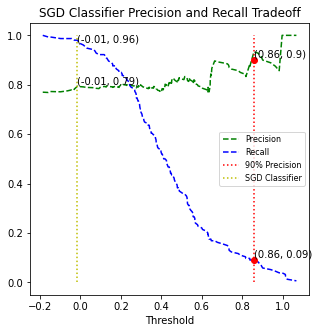

In [ ]:
# plot to show the SGD Classifier trade-off between precision and recall
# find the recall and threshold point when precision is larger or equal to 90%
sgd_test_recall_90_precision = sgd_test_recalls[np.argmax(sgd_test_precisions >= 0.90)]
sgd_test_threshold_90_precision = sgd_test_thresholds[np.argmax(sgd_test_precisions >= 0.90)]

sgd_model_test_precision = precision_score(y_test, sgd_y_test_pred)
sgd_model_test_recall = recall_score(y_test, sgd_y_test_pred)
sgd_model_test_precision_thresholds = sgd_test_thresholds[np.argmax(sgd_test_precisions >= sgd_model_test_precision)]


precios_recall_tradeoff_plot(sgd_test_precisions, sgd_test_recalls, sgd_test_thresholds,
                             0.9, sgd_test_recall_90_precision, sgd_test_threshold_90_precision,
                             sgd_model_test_precision, sgd_model_test_precision_thresholds, sgd_model_test_recall, 0.01)
plt.title("SGD Classifier Precision and Recall Tradeoff")
plt.legend(loc="center right", fontsize=8, labels=["Precision", "Recall", "90% Precision", "SGD Classifier"])
plt.xlabel("Threshold", fontsize=10)
plt.savefig("Test SGD Classifier Precision and Recall Tradeoff")
plt.show()

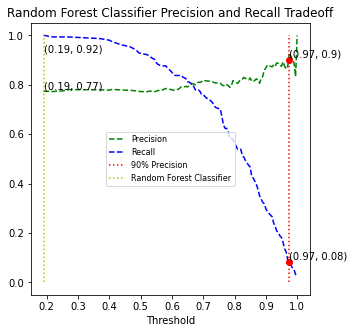

In [ ]:
# plot to show the random forest Classifier trade-off between precision and recall
# find the recall and threshold point when precision is larger or equal to 90%
forest_test_recall_90_precision = forest_test_recalls[np.argmax(forest_test_precisions >= 0.90)]
forest_test_threshold_90_precision = forest_test_thresholds[np.argmax(forest_test_precisions >= 0.90)]

forest_model_test_precision = precision_score(y_test, forest_y_test_pred)
forest_model_test_precision_thresholds = forest_test_thresholds[np.argmax(forest_test_precisions >= forest_model_test_precision)]
forest_model_test_recall = recall_score(y_test, forest_y_test_pred)

precios_recall_tradeoff_plot(forest_test_precisions, forest_test_recalls, forest_test_thresholds,
                             0.9, forest_test_recall_90_precision, forest_test_threshold_90_precision,
                             forest_model_test_precision, forest_model_test_precision_thresholds, forest_model_test_recall, 0.01)
plt.title("Random Forest Classifier Precision and Recall Tradeoff")
plt.legend(loc="center", fontsize=8, labels=["Precision", "Recall", "90% Precision","Random Forest Classifier"])
plt.xlabel("Threshold", fontsize=10)
plt.savefig("Test Random Forest Classifier Precision and Recall Tradeoff")
plt.show()

In [ ]:
# ROC performance measurement 
sgd_test_fpr, sgd_test_tpr, sgd_test_roc_thresholds = roc_curve(y_test, sgd_test_y_score)
forest_test_fpr, forest_test_tpr, forest_test_roc_thresholds = roc_curve(y_test, forest_test_y_scores)

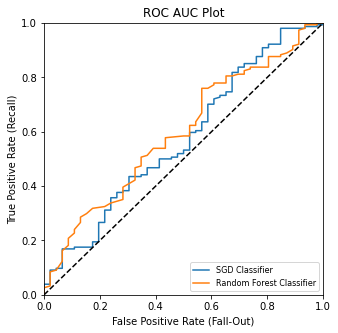

In [ ]:
# RCO performance Measure
plt.figure(figsize=(5, 5))
plt.plot(sgd_test_fpr, sgd_test_tpr, label="SGD Classifier")
plt.plot(forest_test_fpr, forest_test_tpr, label="Random Forest Classifier")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.title("ROC AUC Plot")
plt.legend(loc="lower right", fontsize=8)
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=10) 
plt.ylabel('True Positive Rate (Recall)', fontsize=10)
plt.savefig('Test ROC')
plt.show()

In [ ]:
print("SGD Classifier ROC AUC score:", '%.5f' %  roc_auc_score(y_test, sgd_test_y_score),
      "\nRandom Forest Classifier ROC AUC score:", '%.5f' %  roc_auc_score(y_test, forest_test_y_scores) )

SGD Classifier ROC AUC score: 0.57404 
Random Forest Classifier ROC AUC score: 0.59578


In [ ]:
# Percentage of Loan Active in test Data
print('Percentage of loan active in train data:', 100*sum(test_df['loan_status'])/len(test_df['loan_status']), '%')

Percentage of loan active in train data: 77.0 %
